In [58]:
import os
import cv2
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU, Precision, Recall, Fscore

In [59]:
class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.tiff', '.tif'))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            mask = (mask > 0).float().unsqueeze(0)
        return image, mask

train_transform = A.Compose([
    A.RandomCrop(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.CenterCrop(height=512, width=512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

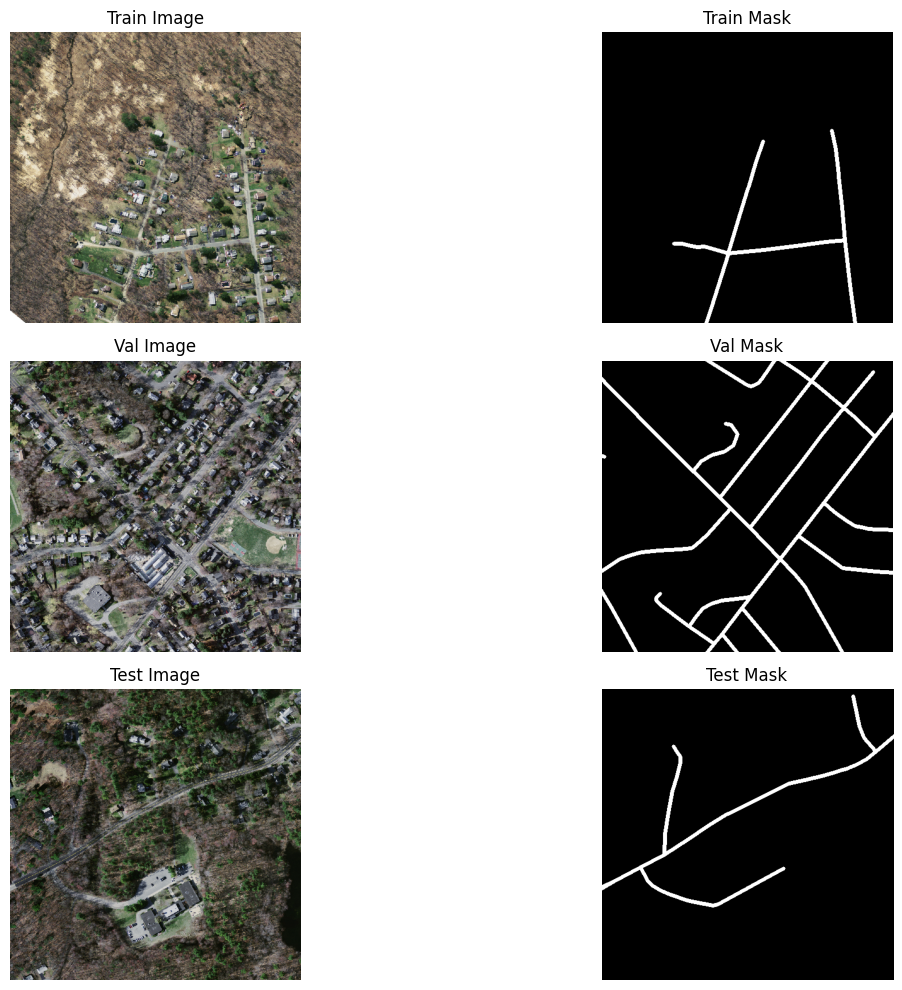

In [78]:
train_images = './MassachusettsRoads/train'
train_masks = './MassachusettsRoads/train_labels'
val_images = './MassachusettsRoads/val'
val_masks = './MassachusettsRoads/val_labels'
test_images = './MassachusettsRoads/test'
test_masks = './MassachusettsRoads/test_labels'

train_dataset = RoadDataset(train_images, train_masks, transform=train_transform)
val_dataset = RoadDataset(val_images, val_masks, transform=val_transform)
test_dataset = RoadDataset(test_images, test_masks, transform=val_transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

train_img, train_mask = train_dataset[0]
val_img, val_mask = val_dataset[0]
test_img, test_mask = test_dataset[0]

train_img = denormalize(train_img).permute(1, 2, 0).numpy()
val_img = denormalize(val_img).permute(1, 2, 0).numpy()
test_img = denormalize(test_img).permute(1, 2, 0).numpy()
train_mask = train_mask.squeeze(0).numpy()
val_mask = val_mask.squeeze(0).numpy()
test_mask = test_mask.squeeze(0).numpy()

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.imshow(train_img)
plt.title("Train Image")
plt.axis('off')
plt.subplot(3, 2, 2)
plt.imshow(train_mask, cmap='gray')
plt.title("Train Mask")
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(val_img)
plt.title("Val Image")
plt.axis('off')
plt.subplot(3, 2, 4)
plt.imshow(val_mask, cmap='gray')
plt.title("Val Mask")
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(test_img)
plt.title("Test Image")
plt.axis('off')
plt.subplot(3, 2, 6)
plt.imshow(test_mask, cmap='gray')
plt.title("Test Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

In [61]:
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", classes=1, activation=None)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

loss_fn = nn.BCEWithLogitsLoss()

iou = IoU(threshold=0.5)
precision = Precision(threshold=0.5)
recall = Recall(threshold=0.5)
fscore = Fscore(threshold=0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

Device: mps


In [62]:
if os.path.exists("best_weights.pth"):
    model.load_state_dict(torch.load("best_weights.pth", map_location=device))
    print(f"Loaded weights from best_weights.pth")

num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_ious = []
val_precisions = []
val_recalls = []
val_fscores = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Train {epoch+1}/{num_epochs}", colour="green"):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    val_iou = 0
    val_precision = 0
    val_recall = 0
    val_fscore = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Val {epoch+1}/{num_epochs}", colour="red"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            val_iou += iou(outputs, masks).item()
            val_precision += precision(outputs, masks).item()
            val_recall += recall(outputs, masks).item()
            val_fscore += fscore(outputs, masks).item()
    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_fscore /= len(val_loader)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_fscores.append(val_fscore)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val Fscore: {val_fscore:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_weights.pth")
        print(f"Model saved with Val Loss: {val_loss:.4f}")

Val 1/50: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Epoch 1, Train Loss: 0.7481, Val Loss: 0.7061, Val IoU: 0.0558, Val Precision: 0.1295, Val Recall: 0.0898, Val Fscore: 0.1057
Model saved with Val Loss: 0.7061


Val 2/50: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Epoch 2, Train Loss: 0.6852, Val Loss: 0.6740, Val IoU: 0.0314, Val Precision: 0.1640, Val Recall: 0.0374, Val Fscore: 0.0609
Model saved with Val Loss: 0.6740


Val 3/50: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch 3, Train Loss: 0.6247, Val Loss: 0.5760, Val IoU: 0.0050, Val Precision: 0.4208, Val Recall: 0.0051, Val Fscore: 0.0100
Model saved with Val Loss: 0.5760


Val 4/50: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 4, Train Loss: 0.5807, Val Loss: 0.5560, Val IoU: 0.0038, Val Precision: 0.4481, Val Recall: 0.0039, Val Fscore: 0.0076
Model saved with Val Loss: 0.5560


Val 5/50: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 5, Train Loss: 0.5589, Val Loss: 0.5263, Val IoU: 0.1046, Val Precision: 0.6901, Val Recall: 0.1098, Val Fscore: 0.1894
Model saved with Val Loss: 0.5263


Val 6/50: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Epoch 6, Train Loss: 0.5209, Val Loss: 0.4543, Val IoU: 0.4501, Val Precision: 0.5627, Val Recall: 0.6943, Val Fscore: 0.6205
Model saved with Val Loss: 0.4543


Val 7/50: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch 7, Train Loss: 0.4686, Val Loss: 0.3967, Val IoU: 0.4911, Val Precision: 0.6378, Val Recall: 0.6827, Val Fscore: 0.6580
Model saved with Val Loss: 0.3967


Val 8/50: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Epoch 8, Train Loss: 0.4360, Val Loss: 0.3800, Val IoU: 0.5172, Val Precision: 0.6189, Val Recall: 0.7586, Val Fscore: 0.6814
Model saved with Val Loss: 0.3800


Val 9/50: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Epoch 9, Train Loss: 0.4254, Val Loss: 0.3700, Val IoU: 0.5241, Val Precision: 0.6245, Val Recall: 0.7651, Val Fscore: 0.6875
Model saved with Val Loss: 0.3700


Val 10/50: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch 10, Train Loss: 0.4167, Val Loss: 0.3576, Val IoU: 0.5332, Val Precision: 0.6371, Val Recall: 0.7651, Val Fscore: 0.6951
Model saved with Val Loss: 0.3576


Val 11/50: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 11, Train Loss: 0.4012, Val Loss: 0.3371, Val IoU: 0.5417, Val Precision: 0.6393, Val Recall: 0.7795, Val Fscore: 0.7024
Model saved with Val Loss: 0.3371


Val 12/50: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Epoch 12, Train Loss: 0.3831, Val Loss: 0.3113, Val IoU: 0.5588, Val Precision: 0.6931, Val Recall: 0.7427, Val Fscore: 0.7167
Model saved with Val Loss: 0.3113


Val 13/50: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Epoch 13, Train Loss: 0.3569, Val Loss: 0.2919, Val IoU: 0.5599, Val Precision: 0.6812, Val Recall: 0.7586, Val Fscore: 0.7175
Model saved with Val Loss: 0.2919


Val 14/50: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Epoch 14, Train Loss: 0.3359, Val Loss: 0.2729, Val IoU: 0.5640, Val Precision: 0.6579, Val Recall: 0.7974, Val Fscore: 0.7209
Model saved with Val Loss: 0.2729


Val 15/50: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Epoch 15, Train Loss: 0.3151, Val Loss: 0.2542, Val IoU: 0.5779, Val Precision: 0.6998, Val Recall: 0.7682, Val Fscore: 0.7322
Model saved with Val Loss: 0.2542


Val 16/50: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Epoch 16, Train Loss: 0.3047, Val Loss: 0.2491, Val IoU: 0.5811, Val Precision: 0.7109, Val Recall: 0.7607, Val Fscore: 0.7347
Model saved with Val Loss: 0.2491


Val 17/50: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Epoch 17, Train Loss: 0.2995, Val Loss: 0.2435, Val IoU: 0.5838, Val Precision: 0.7200, Val Recall: 0.7551, Val Fscore: 0.7369
Model saved with Val Loss: 0.2435


Val 18/50: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch 18, Train Loss: 0.2976, Val Loss: 0.2388, Val IoU: 0.5870, Val Precision: 0.7232, Val Recall: 0.7567, Val Fscore: 0.7394
Model saved with Val Loss: 0.2388


Val 19/50: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch 19, Train Loss: 0.2920, Val Loss: 0.2354, Val IoU: 0.5897, Val Precision: 0.7136, Val Recall: 0.7722, Val Fscore: 0.7416
Model saved with Val Loss: 0.2354


Val 20/50: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Epoch 20, Train Loss: 0.2885, Val Loss: 0.2341, Val IoU: 0.5850, Val Precision: 0.7055, Val Recall: 0.7738, Val Fscore: 0.7379
Model saved with Val Loss: 0.2341


Val 21/50: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Epoch 21, Train Loss: 0.2783, Val Loss: 0.2266, Val IoU: 0.5899, Val Precision: 0.7255, Val Recall: 0.7588, Val Fscore: 0.7417
Model saved with Val Loss: 0.2266


Val 22/50: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Epoch 22, Train Loss: 0.2758, Val Loss: 0.2280, Val IoU: 0.5854, Val Precision: 0.7081, Val Recall: 0.7715, Val Fscore: 0.7382


Val 23/50: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch 23, Train Loss: 0.2702, Val Loss: 0.2184, Val IoU: 0.5929, Val Precision: 0.7217, Val Recall: 0.7684, Val Fscore: 0.7441
Model saved with Val Loss: 0.2184


Val 24/50: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch 24, Train Loss: 0.2664, Val Loss: 0.2132, Val IoU: 0.5970, Val Precision: 0.7405, Val Recall: 0.7551, Val Fscore: 0.7474
Model saved with Val Loss: 0.2132


Val 25/50: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Epoch 25, Train Loss: 0.2689, Val Loss: 0.2120, Val IoU: 0.5899, Val Precision: 0.7285, Val Recall: 0.7556, Val Fscore: 0.7418
Model saved with Val Loss: 0.2120


Val 26/50: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Epoch 26, Train Loss: 0.2612, Val Loss: 0.2092, Val IoU: 0.5908, Val Precision: 0.7477, Val Recall: 0.7384, Val Fscore: 0.7423
Model saved with Val Loss: 0.2092


Val 27/50: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Epoch 27, Train Loss: 0.2468, Val Loss: 0.2048, Val IoU: 0.5949, Val Precision: 0.7423, Val Recall: 0.7501, Val Fscore: 0.7458
Model saved with Val Loss: 0.2048


Val 28/50: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Epoch 28, Train Loss: 0.2524, Val Loss: 0.2013, Val IoU: 0.5979, Val Precision: 0.7432, Val Recall: 0.7529, Val Fscore: 0.7479
Model saved with Val Loss: 0.2013


Val 29/50: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch 29, Train Loss: 0.2424, Val Loss: 0.2002, Val IoU: 0.5955, Val Precision: 0.7436, Val Recall: 0.7491, Val Fscore: 0.7461
Model saved with Val Loss: 0.2002


Val 30/50: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Epoch 30, Train Loss: 0.2415, Val Loss: 0.1990, Val IoU: 0.5975, Val Precision: 0.7230, Val Recall: 0.7743, Val Fscore: 0.7477
Model saved with Val Loss: 0.1990


Val 31/50: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch 31, Train Loss: 0.2402, Val Loss: 0.2008, Val IoU: 0.5901, Val Precision: 0.7416, Val Recall: 0.7426, Val Fscore: 0.7418


Val 32/50: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Epoch 32, Train Loss: 0.2404, Val Loss: 0.1933, Val IoU: 0.6021, Val Precision: 0.7470, Val Recall: 0.7560, Val Fscore: 0.7513
Model saved with Val Loss: 0.1933


Val 33/50: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Epoch 33, Train Loss: 0.2336, Val Loss: 0.1920, Val IoU: 0.6043, Val Precision: 0.7555, Val Recall: 0.7514, Val Fscore: 0.7531
Model saved with Val Loss: 0.1920


Val 34/50: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Epoch 34, Train Loss: 0.2336, Val Loss: 0.1919, Val IoU: 0.6029, Val Precision: 0.7528, Val Recall: 0.7518, Val Fscore: 0.7520
Model saved with Val Loss: 0.1919


Val 35/50: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Epoch 35, Train Loss: 0.2294, Val Loss: 0.1930, Val IoU: 0.6036, Val Precision: 0.7447, Val Recall: 0.7605, Val Fscore: 0.7524


Val 36/50: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Epoch 36, Train Loss: 0.2309, Val Loss: 0.1920, Val IoU: 0.6063, Val Precision: 0.7451, Val Recall: 0.7646, Val Fscore: 0.7546


Val 37/50: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch 37, Train Loss: 0.2307, Val Loss: 0.1901, Val IoU: 0.6061, Val Precision: 0.7532, Val Recall: 0.7563, Val Fscore: 0.7545
Model saved with Val Loss: 0.1901


Val 38/50: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Epoch 38, Train Loss: 0.2339, Val Loss: 0.1879, Val IoU: 0.6094, Val Precision: 0.7602, Val Recall: 0.7543, Val Fscore: 0.7570
Model saved with Val Loss: 0.1879


Val 39/50: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Epoch 39, Train Loss: 0.2319, Val Loss: 0.1864, Val IoU: 0.6136, Val Precision: 0.7558, Val Recall: 0.7655, Val Fscore: 0.7604
Model saved with Val Loss: 0.1864


Val 40/50: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch 40, Train Loss: 0.2309, Val Loss: 0.1877, Val IoU: 0.6096, Val Precision: 0.7641, Val Recall: 0.7510, Val Fscore: 0.7572


Val 41/50: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 41, Train Loss: 0.2281, Val Loss: 0.1864, Val IoU: 0.6142, Val Precision: 0.7632, Val Recall: 0.7588, Val Fscore: 0.7607
Model saved with Val Loss: 0.1864


Val 42/50: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Epoch 42, Train Loss: 0.2289, Val Loss: 0.1842, Val IoU: 0.6146, Val Precision: 0.7597, Val Recall: 0.7627, Val Fscore: 0.7611
Model saved with Val Loss: 0.1842


Val 43/50: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Epoch 43, Train Loss: 0.2349, Val Loss: 0.1849, Val IoU: 0.6154, Val Precision: 0.7487, Val Recall: 0.7755, Val Fscore: 0.7618


Val 44/50: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch 44, Train Loss: 0.2272, Val Loss: 0.1845, Val IoU: 0.6134, Val Precision: 0.7609, Val Recall: 0.7599, Val Fscore: 0.7602


Val 45/50: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 45, Train Loss: 0.2324, Val Loss: 0.1851, Val IoU: 0.6137, Val Precision: 0.7477, Val Recall: 0.7742, Val Fscore: 0.7605


Val 46/50: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch 46, Train Loss: 0.2256, Val Loss: 0.1848, Val IoU: 0.6130, Val Precision: 0.7577, Val Recall: 0.7631, Val Fscore: 0.7600


Val 47/50: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch 47, Train Loss: 0.2255, Val Loss: 0.1791, Val IoU: 0.6225, Val Precision: 0.7709, Val Recall: 0.7639, Val Fscore: 0.7671
Model saved with Val Loss: 0.1791


Val 48/50: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch 48, Train Loss: 0.2309, Val Loss: 0.1808, Val IoU: 0.6211, Val Precision: 0.7643, Val Recall: 0.7682, Val Fscore: 0.7661


Val 49/50: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Epoch 49, Train Loss: 0.2256, Val Loss: 0.1813, Val IoU: 0.6177, Val Precision: 0.7683, Val Recall: 0.7593, Val Fscore: 0.7635


Val 50/50: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

Epoch 50, Train Loss: 0.2243, Val Loss: 0.1822, Val IoU: 0.6176, Val Precision: 0.7600, Val Recall: 0.7674, Val Fscore: 0.7635


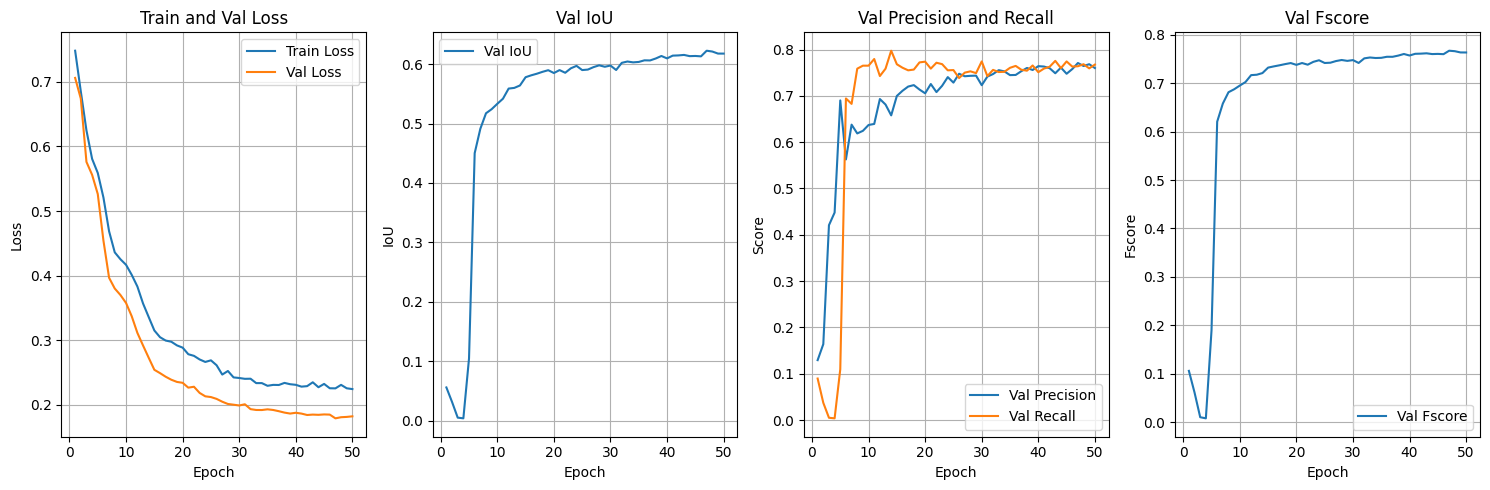

In [63]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 2)
plt.plot(range(1, len(val_ious) + 1), val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Val IoU')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(range(1, len(val_precisions) + 1), val_precisions, label='Val Precision')
plt.plot(range(1, len(val_recalls) + 1), val_recalls, label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Val Precision and Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 4)
plt.plot(range(1, len(val_fscores) + 1), val_fscores, label='Val Fscore')
plt.xlabel('Epoch')
plt.ylabel('Fscore')
plt.title('Val Fscore')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [79]:
model.load_state_dict(torch.load("best_weights.pth", map_location=device))
print(f"Loaded weights from best_weights.pth")

model.eval()
test_iou = 0
test_precision = 0
test_recall = 0
test_fscore = 0
test_predictions = []

with torch.no_grad():
    for i, (images, masks) in enumerate(tqdm(test_loader, desc="Testing", colour="blue")):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        test_iou += iou(outputs, masks).item()
        test_precision += precision(outputs, masks).item()
        test_recall += recall(outputs, masks).item()
        test_fscore += fscore(outputs, masks).item()

        if len(test_predictions) < 3:
            preds = torch.sigmoid(outputs) > 0.5
            preds_np = preds.cpu().numpy().astype(np.uint8)  # (batch_size, 1, H, W)
            for j in range(min(images.size(0), 3 - len(test_predictions))):
                pred = preds_np[j].squeeze(0)  # (H, W)
                test_predictions.append((images[j].cpu(), masks[j].cpu(), torch.tensor(pred, dtype=torch.float32)))

test_iou /= len(test_loader)
test_precision /= len(test_loader)
test_recall /= len(test_loader)
test_fscore /= len(test_loader)
print(f"Test IoU: {test_iou:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test Fscore: {test_fscore:.4f}")

Loaded weights from best_weights.pth


Testing: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]

Test IoU: 0.5590, Test Precision: 0.7878, Test Recall: 0.6720, Test Fscore: 0.7035


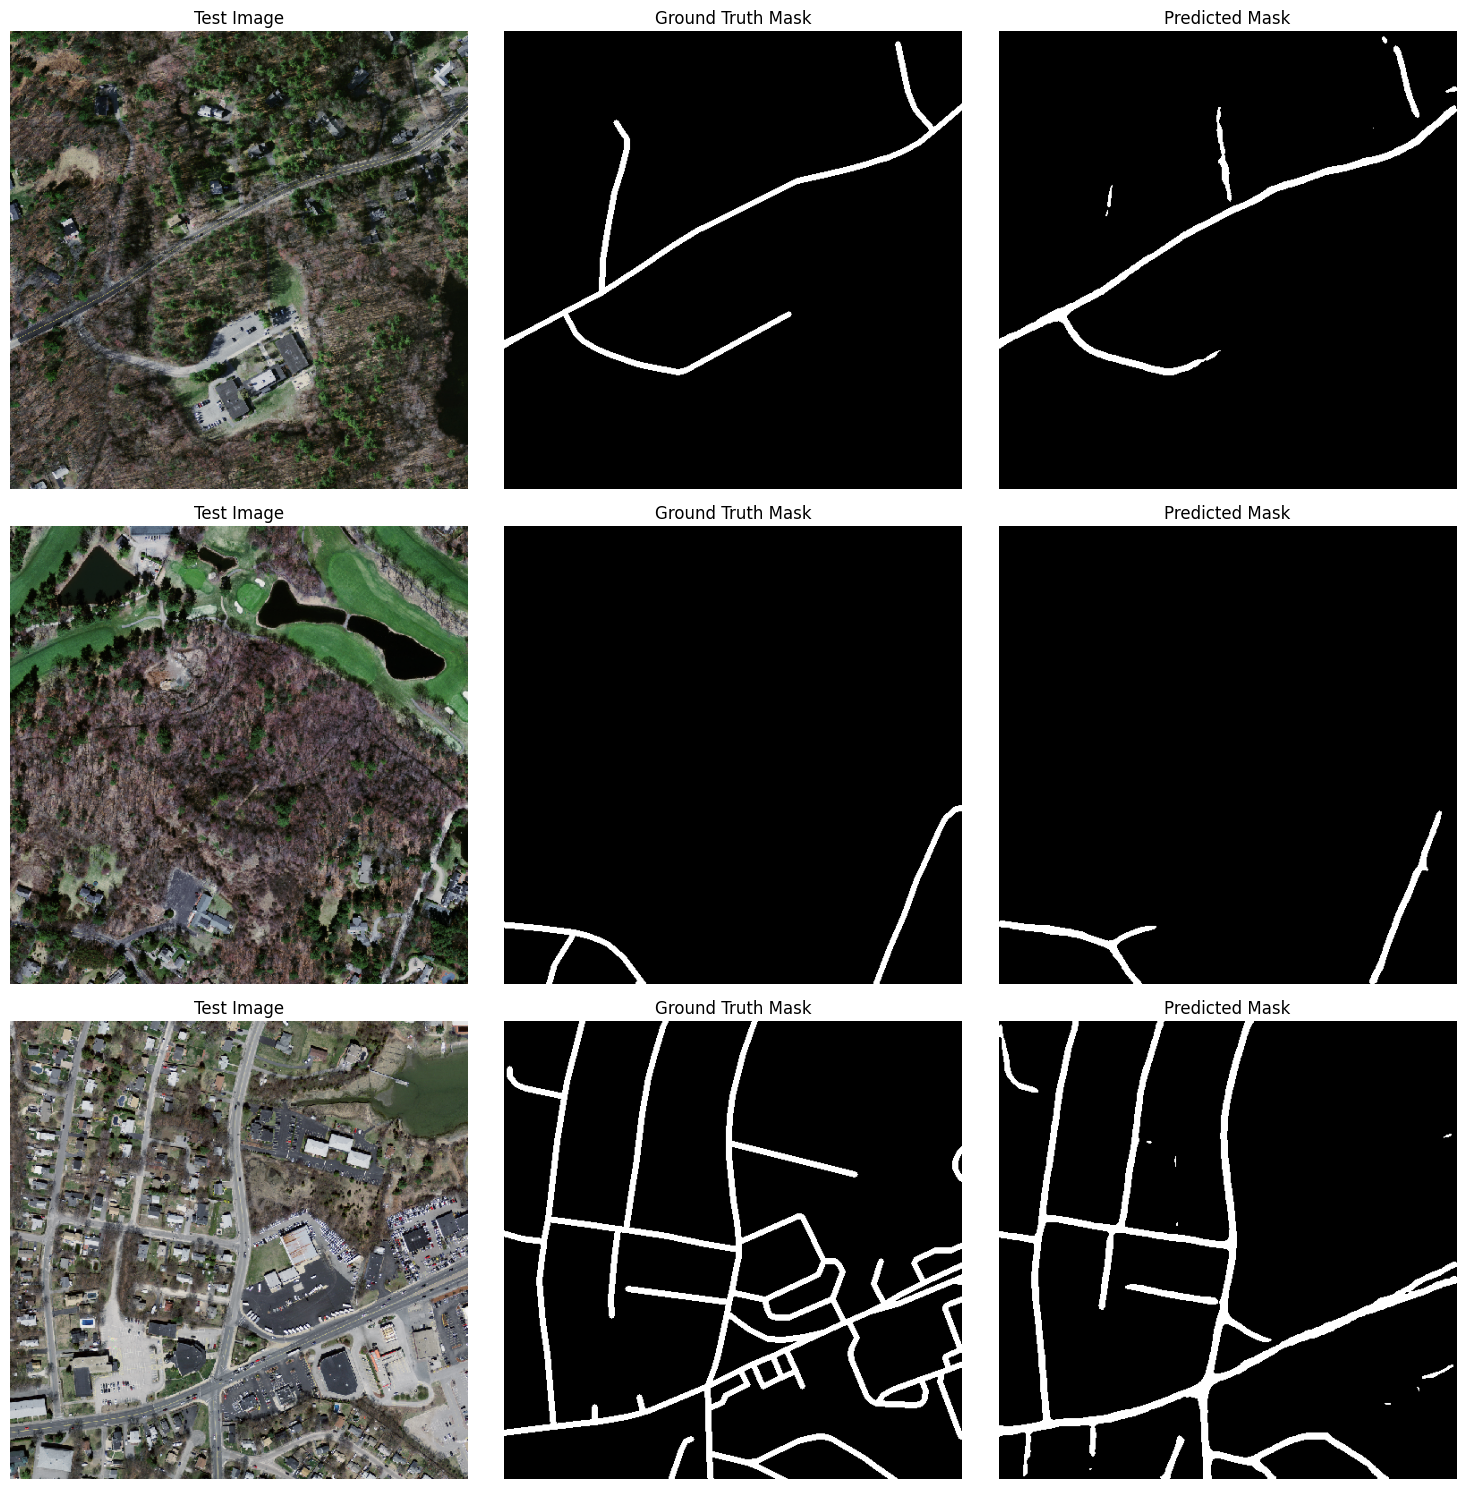

In [80]:
plt.figure(figsize=(15, 5 * 3))
for i, (img, mask, pred) in enumerate(test_predictions):
    img = denormalize(img).permute(1, 2, 0).numpy()
    mask = mask.squeeze(0).numpy()
    pred = pred.numpy()

    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(img)
    plt.title("Test Image")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()